A simple transfer learning trail using the sampled toy dataset from avainsolar images. It follows the tensorflow tutorial: https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub

In this file, you may have a quick look from the In [8], where it get related to our avain dataset.

I manually made a toy dataset using some images from our avain datasets, in this toy dataset, there're three classes: human, wire and other. 

In this trail, we adopt the transfer learning method, which we only train a new top layer on top of the trained classification network (mobilenet_v2) implemented in tensorflow.

While, we see a good sign in this simple training trail, we can see from out [25] and out [26], that the training is doing appropriately, where loss is decreasing and accuracy is increasing. If we compared In [16] and In [28], it seems that transfer learning may work well when we are do transfer learning with our new dataset.

In [1]:
import numpy as np
import time

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


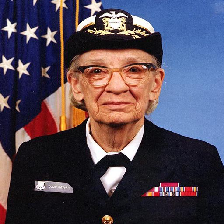

In [2]:
classifier_model ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"

IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,))
])

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [3]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [4]:
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

In [5]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

In [6]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

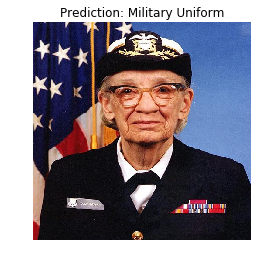

In [7]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

In [8]:
# data_root = tf.keras.utils.get_file(
#   'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
#    untar=True)
# print(data_root)
# data_root_downloads = "/Users/xi/Downloads/flower_photos"
data_root = "/Users/xi/Documents/Argonne/aviansolar-DeepLearning/toy_dataset"

In [9]:
batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  str(data_root),
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 110 files belonging to 3 classes.
Using 88 files for training.


In [10]:
class_names = np.array(train_ds.class_names)
print(class_names)

['human' 'other' 'wire']


In [11]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [14]:
result_batch = classifier.predict(train_ds)

In [15]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['ox', 'thresher', 'ox', 'parallel bars', 'worm fence',
       'safety pin', 'worm fence', 'promontory', 'envelope', 'lipstick',
       'volcano', 'car mirror', 'safety pin', 'thresher', 'pirate',
       'promontory', 'thresher', 'mobile home', 'safety pin',
       'promontory', 'thresher', 'hook', 'bald eagle', 'car mirror',
       'mobile home', 'sloth bear', 'thresher', 'dugong', 'worm fence',
       'thresher', 'worm fence', 'tick', 'wreck', 'promontory',
       'thresher', 'worm fence', 'thresher', 'alp', 'pirate',
       'worm fence', 'thresher', 'wreck', 'Windsor tie', 'thresher',
       'parallel bars', 'mobile home', 'parallel bars', 'Band Aid',
       'safety pin', 'mobile home', 'whistle', 'thresher', 'worm fence',
       'mobile home', 'envelope', 'thresher', 'prison', 'nail',
       'worm fence', 'worm fence', 'safety pin', 'wreck', 'parallel bars',
       'oil filter', 'thresher', 'trailer truck', 'pill bottle',
       'lipstick', 'whistle', 'velvet', 'wreck', 'Arab

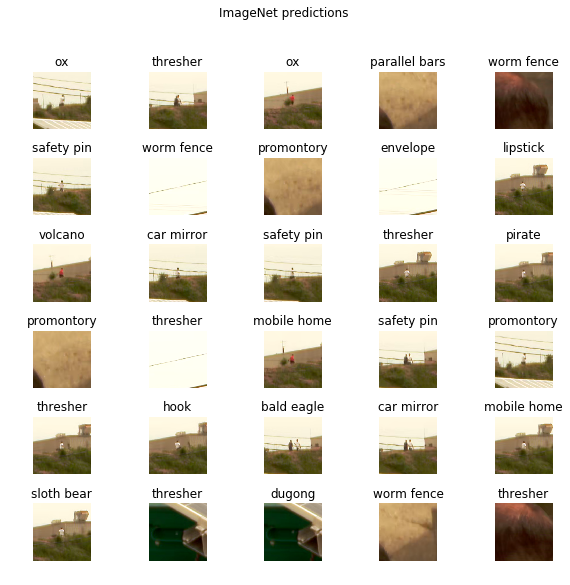

In [16]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

In [17]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

In [36]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [37]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


In [38]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [21]:
predictions = model(image_batch)

In [22]:
predictions.shape

TensorShape([32, 3])

In [23]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

In [24]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

batch_stats_callback = CollectBatchStats()

history = model.fit(train_ds, epochs=4,
                    callbacks=[batch_stats_callback])

Epoch 1/4
3/3 [==============================] - 7s 881ms/step - loss: 0.6771 - acc: 0.6927
Epoch 2/4
3/3 [==============================] - 3s 876ms/step - loss: 0.3183 - acc: 0.8724
Epoch 3/4
3/3 [==============================] - 3s 886ms/step - loss: 0.1385 - acc: 0.9922
Epoch 4/4
3/3 [==============================] - 3s 1s/step - loss: 0.0736 - acc: 1.0000


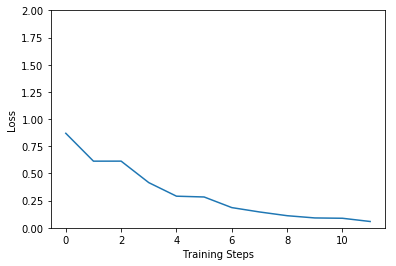

In [25]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

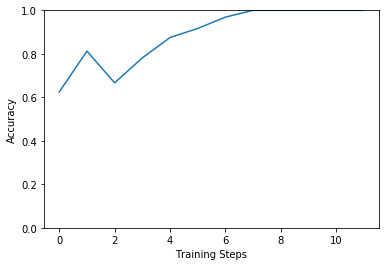

In [26]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

In [27]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

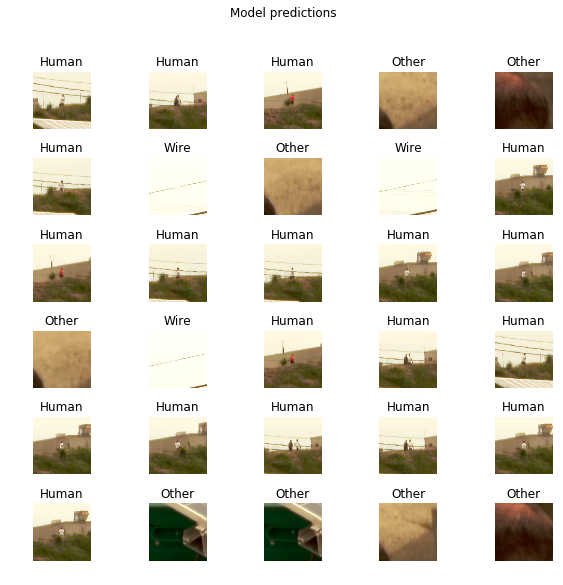

In [28]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")

In [29]:
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
model.save(export_path)

export_path

/Users/xi/anaconda3/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:2320: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
/Users/xi/anaconda3/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:1399: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


INFO:tensorflow:Assets written to: /tmp/saved_models/1609706971/assets


INFO:tensorflow:Assets written to: /tmp/saved_models/1609706971/assets


'/tmp/saved_models/1609706971'

In [30]:
reloaded = tf.keras.models.load_model(export_path)

In [31]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

In [32]:
abs(reloaded_result_batch - result_batch).max()

0.0